# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [9]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic

from Timer import Timer
import logging

In [10]:
import pytest
from ipytest import run_pytest, clean_tests

In [11]:
%setup_logging
%cuda_context_handler context

Global logger already initialized!
Registering context in user workspace
Context already registered! Ignoring


In [12]:
cuda_kernel = """
__global__ void matrixVectorKernel(double* c, double* A, double* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

In [31]:
def gpuMatrixVector(a, b):
    # synchonize to have a nice benchmarking and timing the actual time to do stuffs
    context.synchronize()
    
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    
    # add timer data allocation on gpu
    with Timer("Time to allocate data on GPU") as t:
        a_g = GPUArray(a.shape, np.float64)
        b_g = GPUArray(b.shape, np.float64)
        c_g = GPUArray(a.shape[0], np.float64)
        context.synchronize()
    
    #print(a)
    #print(b)
    
    # add timer import a
    with Timer("Time to import a") as t:
        a_g.set(a)
        context.synchronize()
    
    # add timer import b
    with Timer("Time to import a") as t:
        b_g.set(b)
        context.synchronize()
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (128, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / 128)), 1, 1)
    
    print("Block size is " + str(block_size))
    print("Grid size is " + str(grid_size))
    
    #Execute program on device
    # add timer kernel execution
    with Timer("Time for kernels execution") as t:
        kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)
        context.synchronize()
    
    #Copy data from device to host
    # add timer allocation c
    with Timer("Time to allocate c") as t:
        c = np.empty((a.shape[0],1), dtype=np.float64)
        context.synchronize()
    
    # add timer download c
    with Timer("Time to download c") as t:
        c_g.get(c)
        context.synchronize()
    
    #print(c)
    
    #Return our computed matrix-vector product
    return c

In [32]:
clean_tests()

def test_gpuMatrixVector():
    #Let us test a matrix of size 1x1
    a = np.ones((1,1), dtype=np.float64)
    b = 2*np.ones((1,1), dtype=np.float64)
    c = gpuMatrixVector(a, b)
    print(c)
    assert c == pytest.approx(2.0)
    
    #Test the inner product works
    a = np.ones((1,2), dtype=np.float64)
    b = 2*np.ones((2,1), dtype=np.float64)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(4.0)
    
    #Test a general matrix
    test_size = (4, 3)
    a = np.random.random(test_size).astype(np.float64)
    b = np.random.random((test_size[1], 1)).astype(np.float64)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(np.dot(a,b))
    
run_pytest(filename='MatrixVectorTestingDouble.ipynb', pytest_options=['-vvv'])

============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/ubuntu/jupyter_notebooks/Colombi_Francesco/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

MatrixVectorTestingDouble.py::test_gpuMatrixVector <- <ipython-input-32-ffc1baf8abac> 

Time to allocate data on GPU: 0.529766 ms
Time to import a: 0.234365 ms
Time to import a: 0.207424 ms
Time for kernels execution: 0.425100 ms
Time to allocate c: 0.034809 ms
Time to download c: 0.267744 ms
Time to allocate data on GPU: 0.337362 ms
Time to import a: 0.143051 ms
Time to import a: 0.456810 ms
Time for kernels execution: 0.122547 ms
Time to allocate c: 0.034094 ms
Time to download c: 0.176191 ms
Time to allocate data on GPU: 0.325918 ms
Time to import a: 0.159979 ms
Time to import a: 0.135183 ms
Time for kernels execution: 0.138044 ms
Time to allocate c: 0.033617 ms
Time to download c: 0.181198 ms


PASSED [100%]

=============================== warnings summary ===============================
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x

-- Docs: https://docs.pytest.org/en/latest/warnings.html
===================== 1 passed, 3 warnings in 0.05 seconds =====================


0

In [33]:
# dimension for test for computational time
nx = np.array([200,400,800,1600,3200,6400])
ny = nx

times = np.empty(len(nx))

Time to init a and b on CPU: 12.111902 ms
Time to allocate data on GPU: 0.507355 ms
Time to import a: 0.828505 ms
Time to import a: 0.202179 ms
Time for kernels execution: 0.910997 ms
Time to allocate c: 0.022888 ms
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Time to download c: 0.217438 ms
Time to init a and b on CPU: 8.178949 ms
Time to init a and b on CPU: 2.845764 ms
Time to allocate data on GPU: 0.393629 ms
Time to import a: 0.726223 ms
Time to import a: 0.094175 ms
Time for kernels execution: 0.416279 ms
Time to allocate c: 0.029325 ms
Time to download c: 0.134945 ms
Time to init a and b on CPU: 6.770372 ms
Time to init a and b on CPU: 12.346745 ms
Time to allocate data on GPU: 0.507116 ms
Time to import a: 1.064062 ms
Time to import a: 0.097513 ms
Time for kernels execution: 1.522303 ms
Time to allocate c: 0.024080 ms
Time to download c: 0.

N = 200
Block size is (128, 1, 1)
Grid size is (2, 1, 1)
N = 400
Block size is (128, 1, 1)
Grid size is (4, 1, 1)
N = 800
Block size is (128, 1, 1)
Grid size is (7, 1, 1)
N = 1600
Block size is (128, 1, 1)
Grid size is (13, 1, 1)
N = 3200


Time to init a and b on CPU: 208.289862 ms
Time to allocate data on GPU: 0.849962 ms
Time to import a: 11.268139 ms
Time to import a: 0.681162 ms
Time for kernels execution: 3.729343 ms
Time to allocate c: 0.024796 ms
Time to download c: 1.266718 ms
Time to init a and b on CPU: 32.721043 ms


Block size is (128, 1, 1)
Grid size is (25, 1, 1)
N = 6400


Time to init a and b on CPU: 820.118189 ms
Time to allocate data on GPU: 1.070499 ms
Time to import a: 55.945158 ms
Time to import a: 0.253201 ms
Time for kernels execution: 14.274359 ms
Time to allocate c: 0.040054 ms
Time to download c: 0.374079 ms
Time to init a and b on CPU: 118.479013 ms


Block size is (128, 1, 1)
Grid size is (50, 1, 1)
[  8.17894936   6.77037239   8.81767273  13.52095604  32.72104263
 118.47901344]


/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


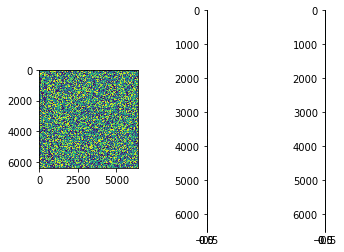

In [34]:
for i in range(len(nx)):    
    #Size of our test
    #test_size = (4, 3)
    print("N = " + str(nx[i]))
    test_size = (nx[i], ny[i])
    
    #Create test input / output data
    with Timer("Time to init a and b on CPU") as t:
        a = np.random.random(test_size).astype(np.float64)
        b = np.random.random((test_size[1], 1)).astype(np.float64)
    with Timer("Time to init a and b on CPU") as t:
        c = gpuMatrixVector(a, b)
        
    times[i] = t.msecs


print(times)
    
fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()

In [35]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

Sad = 9.709705633878456865204498171806
Per element error: 0.001517141505293509


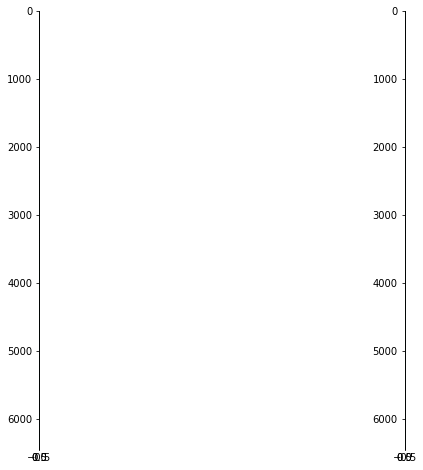

In [36]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)